In [1]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash

    !pip -q install gymnasium[mujoco]==1.0.0

    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

bash: ../xvfb: No such file or directory


In [2]:
from tqdm import tqdm

In [3]:
import gymnasium as gym

ENV_NAME = "HalfCheetah-v5"


def make_env(**kwargs):
    return gym.make(ENV_NAME, **kwargs)


env = make_env(render_mode="rgb_array")
print("Observation space: ", env.observation_space)
print("Action space: ", env.action_space)

Observation space:  Box(-inf, inf, (17,), float64)
Action space:  Box(-1.0, 1.0, (6,), float32)


In [5]:
!pip install mujoco

# Set up GPU rendering.
# from google.colab import files
import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

# Check if installation was succesful.
try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Other imports and helper functions
import time
import itertools
import numpy as np

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

from IPython.display import clear_output
clear_output()

In [6]:
xml = """
<mujoco>
  <worldbody>
    <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
    <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(xml)

In [7]:
import matplotlib.pyplot as plt

env.reset()
plt.imshow(env.render())

FatalError: gladLoadGL error

In [8]:
from gymnasium.vector import AsyncVectorEnv
from gymnasium.wrappers.vector import (
    NormalizeObservation,
    NormalizeReward,
    ClipReward,
    RecordEpisodeStatistics,
)


def make_vec_env(num_envs, **kwargs):
    """Creates a vectorized Atari environment with preprocessing."""

    # Create a list of environment initialization functions
    env_fns = [lambda: make_env(**kwargs) for i in range(num_envs)]
    envs = AsyncVectorEnv(env_fns, shared_memory=True)
    envs = RecordEpisodeStatistics(envs, buffer_length=100000)

    # Use running statistics to scale observation
    # To have zero mean and unit std
    envs = NormalizeObservation(envs)

    # Use running std to scale reward
    envs = NormalizeReward(envs, gamma=0.99)

    # Clip reward after normalization
    envs = ClipReward(envs, min_reward=-10, max_reward=10)

    return envs


# Parameters
n_envs = 2  # Number of parallel environments
# Create the vectorized environment
vec_env = make_vec_env(n_envs)

In [9]:
# import tensorflow as tf
import torch

from torch import nn
from torch.nn import functional as F
import torch


class PolicyModel(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.h = 64

        self.policy_model = nn.Sequential(
            nn.Linear(state_dim, self.h),
            nn.Tanh(),
            nn.Linear(self.h, self.h),
            nn.Tanh(),
            nn.Linear(self.h, 2 * action_dim)
        )

        self.value_model = nn.Sequential(
            nn.Linear(state_dim, self.h),
            nn.Tanh(),
            nn.Linear(self.h, self.h),
            nn.Tanh(),
            nn.Linear(self.h, 1)
        )

    def get_policy(self, x):
        result = self.policy_model(x)
        mean, var = result.chunk(2, dim=-1)
        return mean, F.softplus(var)

    def get_value(self, x):
        return self.value_model(x)

    def forward(self, x):
        policy = self.get_policy(x)
        value = self.get_value(x)

        return policy, value

In [10]:
from torch.distributions.multivariate_normal import MultivariateNormal


class Policy:
    def __init__(self, model):
        self.model = model

    def act(self, inputs, training=False):
        # Free colab dont have enough cuda :(
        inputs = torch.tensor(inputs, dtype=torch.float32, device="cpu")

        mean, var = self.model.get_policy(inputs)
        cov_matrix = torch.diag_embed(var)
        normal_distr = MultivariateNormal(mean, cov_matrix)

        actions = normal_distr.sample()
        log_probs = normal_distr.log_prob(actions)

        values = self.model.get_value(inputs)

        if training:
            return {"distribution": normal_distr, "values": values.squeeze()}

        return {
            "actions": actions.cpu().numpy().squeeze(),
            "log_probs": log_probs.detach().cpu().numpy().squeeze(),
            "values": values.detach().cpu().numpy().squeeze(),
        }

In [11]:
class AsArray:
    """
    Converts lists of interactions to ndarray.
    """

    def __call__(self, trajectory):
        # Modify trajectory inplace.
        for k, v in filter(lambda kv: kv[0] != "state", trajectory.items()):
            trajectory[k] = np.asarray(v)

In [12]:
""" RL env runner """

from collections import defaultdict

import numpy as np


class EnvRunner:
    """Reinforcement learning runner in an environment with given policy"""

    def __init__(self, env, policy, rollout_length, transforms=None, step_var=None):
        self.env = env
        self.policy = policy
        self.rollout_length = rollout_length
        self.transforms = transforms or []
        self.step_var = step_var if step_var is not None else 0
        self.state = {"latest_observation": self.env.reset()[0]}

    @property
    def num_envs(self):
        """Returns number of batched envs or `None` if env is not batched"""
        return getattr(self.env, "num_envs", None)

    def reset(self, **kwargs):
        """Resets env and runner states."""
        self.state["latest_observation"], info = self.env.reset(**kwargs)
        self.policy.reset()

    def get_next(self):
        """Runs the agent in the environment."""
        trajectory = defaultdict(list, {"actions": []})
        observations = []
        rewards = []
        resets = []
        self.state["env_steps"] = self.rollout_length

        for i in range(self.rollout_length):
            observations.append(self.state["latest_observation"])
            act = self.policy.act(self.state["latest_observation"])
            if "actions" not in act:
                raise ValueError(
                    "result of policy.act must contain 'actions' "
                    f"but has keys {list(act.keys())}"
                )
            for key, val in act.items():
                trajectory[key].append(val)

            obs, rew, terminated, truncated, _ = self.env.step(
                trajectory["actions"][-1]
            )
            done = np.logical_or(terminated, truncated)
            self.state["latest_observation"] = obs
            rewards.append(rew)
            resets.append(done)
            self.step_var += self.num_envs or 1

            # Only reset if the env is not batched. Batched envs should
            # auto-reset.
            if not self.num_envs and np.all(done):
                self.state["env_steps"] = i + 1
                self.state["latest_observation"] = self.env.reset()[0]

        trajectory.update(observations=observations, rewards=rewards, resets=resets)
        trajectory["state"] = self.state

        for transform in self.transforms:
            transform(trajectory)
        return trajectory

In [14]:
class GAE:
    """Generalized Advantage Estimator."""

    def __init__(self, policy, gamma=0.99, lambda_=0.95):
        self.policy = policy
        self.gamma = gamma
        self.lambda_ = lambda_

    def __call__(self, trajectory):
        gamma = self.gamma
        lambda_ = self.lambda_

        # GAE results
        trajectory['advantages'] = []
        trajectory['value_targets'] = []

        r = trajectory['rewards']
        resets = trajectory['resets'] # check terminal state

        V_pi = list(trajectory["values"])
        latest_observation_act_results = self.policy.act(trajectory['state']['latest_observation'])
        V_pi.append(latest_observation_act_results['values'])

        # Compute advantages in reverse -> no need to recalc the sum on each iter
        advantage = 0.0
        for l in reversed(range(len(V_pi) - 1)):
            delta_t = r[l] + gamma * V_pi[l + 1] * ~resets[l] - V_pi[l]

            # Recalc advantage for next t
            advantage = advantage * gamma * lambda_ * ~resets[l]
            advantage += delta_t

            value_target = advantage + V_pi[l]

            trajectory['advantages'].append(advantage)
            trajectory['value_targets'].append(value_target)

        # Reverse calculated advantages
        trajectory['advantages'] = np.array(trajectory['advantages'][::-1])
        trajectory['value_targets'] = np.array(trajectory['value_targets'][::-1])

**Test GAE**

In [15]:
# !curl -O https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week09_policy_II/test_ppo/actions.npy
# !curl -O https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week09_policy_II/test_ppo/log_probs.npy
# !curl -O https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week09_policy_II/test_ppo/values.npy
# !curl -O https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week09_policy_II/test_ppo/observations.npy
# !curl -O https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week09_policy_II/test_ppo/rewards.npy
# !curl -O https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week09_policy_II/test_ppo/resets.npy
# !curl -O https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week09_policy_II/test_ppo/state.npy
# !curl -O https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week09_policy_II/test_ppo/advantages.npy
# !curl -O https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week09_policy_II/test_ppo/value_targets.npy
# !curl -O https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week09_policy_II/test_ppo/policy

In [21]:
def test_gae():
    trajectory = {}
    for key in ["actions", "log_probs", "values", "observations", "rewards", "resets"]:
        trajectory[key] = np.load(f"{key}.npy", allow_pickle=True)
    trajectory["state"] = {"latest_observation": np.array([np.load("state.npy")])}

    policy = torch.load(f"policy", weights_only=False)
    policy.model = policy.model.cpu() # Free colab dont have cuda :(
    gae_to_test = GAE(policy, gamma=0.99, lambda_=0.95)

    gae_to_test(trajectory)

    for key in ["advantages", "value_targets"]:
        expected = np.load(f"{key}.npy")
        generated = trajectory[key]
        assert np.allclose(expected.ravel(), generated.ravel(), atol=2e-2), key

    print("All passed")


test_gae()

All passed


In [22]:
def flatten_first_two_dims(arr):
    if arr.ndim == 2:
        return arr.reshape(-1)
    return arr.reshape(arr.shape[0] * arr.shape[1], *arr.shape[2:])


class TrajectorySampler:
    """Samples minibatches from trajectory for a number of epochs."""

    def __init__(self, runner, num_epochs, num_minibatches, transforms=None):
        self.runner = runner
        self.num_epochs = num_epochs
        self.num_minibatches = num_minibatches
        self.transforms = transforms or []
        self.minibatch_count = 0
        self.epoch_count = 0
        self.trajectory = None

    def shuffle_trajectory(self):
        """Shuffles all elements in trajectory.

        Should be called at the beginning of each epoch.
        """
        trajectory_len = len(self.trajectory["observations"])

        permutation = np.random.permutation(trajectory_len)
        for key, value in self.trajectory.items():
            if key != "state":
                self.trajectory[key] = value[permutation]

    def squeeze_trajectory(self):
        for key, value in self.trajectory.items():
            if key != "state":
                self.trajectory[key] = flatten_first_two_dims(value)

    def get_trajectory(self):
        self.trajectory = self.runner.get_next()
        self.squeeze_trajectory()

    def get_next(self):
        """Returns next minibatch."""
        if not self.trajectory:
            self.get_trajectory()

        if self.minibatch_count == self.num_minibatches:
            self.shuffle_trajectory()
            self.minibatch_count = 0
            self.epoch_count += 1

        if self.epoch_count == self.num_epochs:
            self.get_trajectory()
            self.shuffle_trajectory()
            self.minibatch_count = 0
            self.epoch_count = 0

        trajectory_len = self.trajectory["observations"].shape[0]

        batch_size = trajectory_len // self.num_minibatches

        minibatch = {}
        for key, value in self.trajectory.items():
            if key != "state":
                minibatch[key] = value[
                    self.minibatch_count
                    * batch_size : (self.minibatch_count + 1)
                    * batch_size
                ]

        self.minibatch_count += 1

        for transform in self.transforms:
            transform(minibatch)

        return minibatch

In [23]:
class NormalizeAdvantages:
    """Normalizes advantages to have zero mean and unit std."""

    def __call__(self, trajectory):
        advantages = trajectory["advantages"]

        mean = advantages.mean()
        std = advantages.std()

        trajectory["advantages"] = (advantages - mean) / std

In [24]:
def make_ppo_sampler(
    env,
    policy,
    num_runner_steps=2048,
    gamma=0.99,
    lambda_=0.95,
    num_epochs=10,
    num_minibatches=32,
):
    """Creates runner for PPO algorithm."""
    runner_transforms = [AsArray(), GAE(policy, gamma=gamma, lambda_=lambda_)]
    runner = EnvRunner(env, policy, num_runner_steps, transforms=runner_transforms)

    sampler_transforms = [NormalizeAdvantages()]
    sampler = TrajectorySampler(
        runner,
        num_epochs=num_epochs,
        num_minibatches=num_minibatches,
        transforms=sampler_transforms,
    )
    return sampler

In the next cell you will need to implement Proximal Policy Optimization algorithm itself. The algorithm
modifies the typical policy gradient loss in the following way:

$$
J_{\pi}(s, a) = \frac{\pi_\theta(a|s)}{\pi_\theta^{\text{old}}(a|s)} \cdot A^{\mathrm{GAE}(\gamma,\lambda)}(s, a)
$$

$$
J_{\pi}^{\text{clipped}}(s, a) = \mathrm{clip}\left(
\frac{\pi_\theta(a|s)}{\pi_{\theta^{\text{old}}}(a|s)},
1 - \text{cliprange}, 1 + \text{cliprange}\right)\cdot A^{\mathrm{GAE(\gamma, \lambda)}}(s, a)\\
$$

$$
L_{\text{policy}} = -\frac{1}{T}\sum_{t=0}^{T-1}\min\left(J_\pi(s_{t}, a_{t}), J_{\pi}^{\text{clipped}}(s_{t}, a_{t})\right).
$$

The value loss is also modified:

$$
L_{V}^{\text{clipped}} = \frac{1}{T}\sum_{t=0}^{T-1} \max(l^{simple}(s_{t}), l^{clipped}(s_{t}))
$$
, where $l^{simple}$ is your standard critic loss
$$
l^{simple}(s_{t}) = [V_\theta(s_{t}) - \hat{V}(s_{t})]^2
$$

and $l^{clipped}$ is a clipped version that limits large changes of the value function:
$$
l^{clipped}(s_{t}) = [
V_{\theta^{\text{old}}}(s_{t}) +
\text{clip}\left(
V_\theta(s_{t}) - V_{\theta^\text{old}}(s_{t}),
-\text{cliprange}, \text{cliprange}
\right) - \hat{V}(s_{t})] ^ 2
$$

In [25]:
class PPO:
    def __init__(
        self, policy, optimizer, cliprange=0.2, value_loss_coef=0.25, max_grad_norm=0.5
    ):
        self.policy = policy
        self.optimizer = optimizer
        self.cliprange = cliprange
        self.value_loss_coef = value_loss_coef
        # Note that we don't need entropy regularization for this env.
        self.max_grad_norm = max_grad_norm

    def policy_loss(self, trajectory, act):
        """Computes and returns policy loss on a given trajectory."""
        advantages, actions, distr = torch.tensor(trajectory["advantages"]), torch.tensor(trajectory["actions"]), act["distribution"]

        old_log_probs = torch.tensor(trajectory["log_probs"])
        new_log_probs = distr.log_prob(actions)

        probs_coeff = torch.exp(new_log_probs - old_log_probs)

        J = probs_coeff * advantages
        J_clipped = torch.clamp(probs_coeff, 1 - self.cliprange, 1 + self.cliprange) * advantages

        return -torch.mean(torch.min(J, J_clipped))

    def value_loss(self, trajectory, act):
        """Computes and returns value loss on a given trajectory."""
        V, V_old, V_target = act['values'], torch.tensor(trajectory['values']), torch.tensor(trajectory["value_targets"])

        l_simple = (V - V_target) ** 2
        l_clipped = (V_old + torch.clamp(V - V_old, -self.cliprange, self.cliprange) - V_target) ** 2

        return torch.mean(torch.max(l_simple, l_clipped))

    def loss(self, trajectory):
        act = self.policy.act(trajectory["observations"], training=True)

        policy_loss_value = self.policy_loss(trajectory, act)
        value_loss_value = self.value_loss(trajectory, act)

        total_loss = policy_loss_value + self.value_loss_coef * value_loss_value
        return total_loss

    def step(self, trajectory):
        """Computes the loss function and performs a single gradient step."""
        self.optimizer.zero_grad()

        loss = self.loss(trajectory).backward()
        nn.utils.clip_grad_norm_(self.policy.model.parameters(), self.max_grad_norm)

        self.optimizer.step()

In [26]:
import torch
import torch.nn as nn
import copy

class DecoupledPPO:
    def __init__(self, policy, optimizer, cliprange=0.2, value_loss_coef=0.5,
                 max_grad_norm=0.5, beta_ewma=0.99):
        """
        policy: your main (live) policy model (nn.Module).
        lr, cliprange, etc.: typical PPO hyperparams.
        beta_ewma: decay rate for the EWMA “proximal policy”.
        """
        self.policy = policy  # pi_behav = pi_theta
        self.cliprange = cliprange
        self.value_loss_coef = value_loss_coef
        self.max_grad_norm = max_grad_norm
        self.optimizer = optimizer

        self.policy_prox = copy.deepcopy(policy) # pi_proxy
        for p in self.policy_prox.model.parameters():
            p.requires_grad = False

        self.beta_ewma = beta_ewma

    def update_prox_policy(self):
        with torch.no_grad():
            for p_main, p_prox in zip(self.policy.model.parameters(),
                                      self.policy_prox.model.parameters()):
                p_prox.data.mul_(self.beta_ewma).add_(
                    p_main.data, alpha=(1.0 - self.beta_ewma)
                )

    def policy_loss(self, trajectory, curr_act, proxy_act):
        actions = torch.tensor(trajectory["actions"])
        advantages = torch.tensor(trajectory["advantages"], dtype=torch.float)

        current_distr = curr_act["distribution"]
        new_log_probs = current_distr.log_prob(actions)

        with torch.no_grad():
            prox_distr = proxy_act["distribution"]
            old_log_probs = prox_distr.log_prob(actions)

        ratio = (new_log_probs - old_log_probs).exp()

        # PPO clipping
        ratio_clipped = torch.clamp(ratio, 1.0 - self.cliprange, 1.0 + self.cliprange)
        policy_loss_ = -torch.mean(torch.min(ratio * advantages, ratio_clipped * advantages))

        return policy_loss_

    def value_loss(self, trajectory, curr_act, proxy_act):
        """
        Value loss with clipping (optional).
        We'll treat self.policy as having a .value(obs) that returns V(s).
        """
        returns = torch.tensor(trajectory["value_targets"], dtype=torch.float)

        values = curr_act['values']
        with torch.no_grad():
            old_values = proxy_act['values']

        unclipped_loss = (values - returns)**2
        clipped_values = old_values + torch.clamp(values - old_values,
                                                 -self.cliprange, self.cliprange)
        clipped_loss = (clipped_values - returns)**2

        value_loss_ = torch.mean(torch.max(unclipped_loss, clipped_loss))
        return value_loss_

    def loss(self, trajectory):
        """
        Combine policy + value losses into total PPO loss.
        """
        curr_act = self.policy.act(trajectory["observations"], training=True)
        with torch.no_grad():
            prox_act = self.policy_prox.act(trajectory["observations"], training=True)

        p_loss = self.policy_loss(trajectory, curr_act, prox_act)
        v_loss = self.value_loss(trajectory, curr_act, prox_act)
        total = p_loss + self.value_loss_coef * v_loss
        return total

    def step(self, trajectory):
        """
        A single PPO update using the decoupled objective.
        Then update self.policy_prox with an EWMA.
        """
        self.optimizer.zero_grad()
        total_loss = self.loss(trajectory)
        total_loss.backward()

        # Clip gradients
        nn.utils.clip_grad_norm_(self.policy.model.parameters(), self.max_grad_norm)
        self.optimizer.step()

        # Now update the proximal policy (EWMA)
        self.update_prox_policy()

        return total_loss.item()


In [27]:
import math
import torch

def rescale_adam(optimizer: torch.optim.Optimizer, C: float):
    for param_group in optimizer.param_groups:
        if "lr" in param_group:
            old_lr = param_group["lr"]
            new_lr = old_lr / math.sqrt(C)
            param_group["lr"] = new_lr

        if "betas" in param_group:
            old_betas = param_group["betas"]  # (beta1, beta2)
            beta1_rescaled = old_betas[0] ** (1.0 / C)
            beta2_rescaled = old_betas[1] ** (1.0 / C)

            # TODO: Maybe add clamp for small betas?
            param_group["betas"] = (beta1_rescaled, beta2_rescaled)

In [28]:
state_dim = vec_env.single_observation_space.shape[0]
action_dim = vec_env.single_action_space.shape[0]

model = PolicyModel(state_dim, action_dim)
model = model.cpu() # Free colab dont have cuda :(

policy = Policy(model)

num_envs = 2

num_default_minibatches = 32
num_minibatches = 8

vec_env = make_vec_env(num_envs=num_envs)
sampler = make_ppo_sampler(
    vec_env,
    policy,
    num_minibatches=num_minibatches)

optimizer = torch.optim.Adam(policy.model.parameters(), lr=3e-4, eps=1e-5)
rescale_adam(optimizer=optimizer, C=num_default_minibatches / num_minibatches)
n_iter = 250000

lr_mult = lambda epoch: (1 - (epoch / n_iter))
sched = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_mult)

ppo = DecoupledPPO(policy, optimizer)

In [29]:
from IPython.display import clear_output
from matplotlib import pyplot as plt

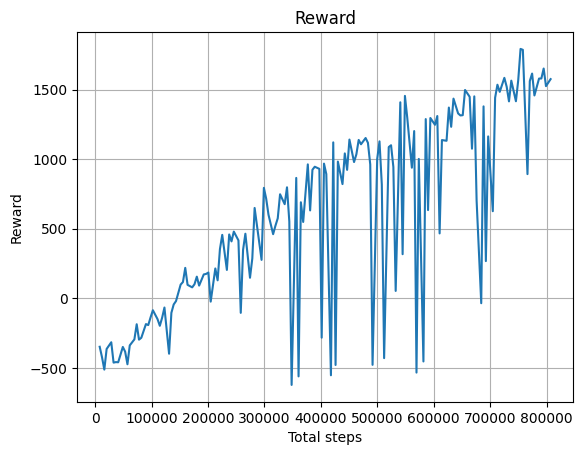

  6%|▋         | 15703/250000 [09:54<2:27:51, 26.41it/s]


KeyboardInterrupt: 

In [30]:
steps = []
rewards = []

for i in tqdm(range(n_iter)):
    trajectory = sampler.get_next()

    if (i + 1) % 100 == 0:
        clear_output(True)
        rewards.append(vec_env.env.env.env.return_queue[-1])
        steps.append(sampler.runner.step_var)

        plt.plot(steps, rewards, label="episode rewards")
        plt.title("Reward")
        plt.xlabel("Total steps")
        plt.ylabel("Reward")
        plt.grid()
        plt.show()

    ppo.step(trajectory)
    sched.step()

In [31]:
state_dim = vec_env.single_observation_space.shape[0]
action_dim = vec_env.single_action_space.shape[0]

model = PolicyModel(state_dim, action_dim)
model = model.cpu() # Free colab dont have cuda :(

policy = Policy(model)

num_envs = 2

num_default_minibatches = 8
num_minibatches = 8

vec_env = make_vec_env(num_envs=num_envs)
sampler = make_ppo_sampler(
    vec_env,
    policy,
    num_minibatches=num_minibatches)

optimizer = torch.optim.Adam(policy.model.parameters(), lr=3e-4, eps=1e-5)
rescale_adam(optimizer=optimizer, C=num_default_minibatches / num_minibatches)
n_iter = 250000

lr_mult = lambda epoch: (1 - (epoch / n_iter))
sched = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_mult)

ppo = DecoupledPPO(policy, optimizer)

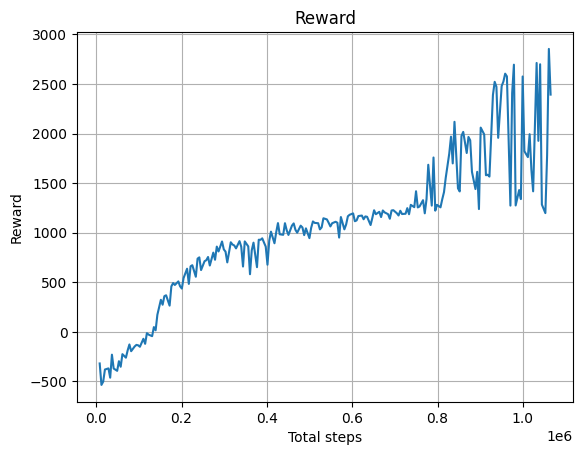

  8%|▊         | 20880/250000 [12:16<2:14:44, 28.34it/s]


KeyboardInterrupt: 

In [32]:
steps = []
rewards = []

for i in tqdm(range(n_iter)):
    trajectory = sampler.get_next()

    if (i + 1) % 100 == 0:
        clear_output(True)
        rewards.append(vec_env.env.env.env.return_queue[-1])
        steps.append(sampler.runner.step_var)

        plt.plot(steps, rewards, label="episode rewards")
        plt.title("Reward")
        plt.xlabel("Total steps")
        plt.ylabel("Reward")
        plt.grid()
        plt.show()

    ppo.step(trajectory)
    sched.step()

## Evaluation

In [79]:
def evaluate(env, actor, n_games=1, t_max=1000):
    """
    Plays n_games and returns rewards and rendered games
    """
    rewards = []

    for _ in range(n_games):
        s, _ = env.reset()

        R = 0
        for _ in range(t_max):
            # select action for final evaluation of your policy
            action = actor.act(np.array([s]), training=False)["actions"]

            s, r, terminated, truncated, _ = env.step(action)

            R += r

            if terminated or truncated:
                break

        rewards.append(R)
    return np.array(rewards)

In [80]:
from gymnasium.wrappers import (
    RecordVideo,
    NormalizeObservation as SingleEnvNormalization,
)

# let's hope this will work
# don't forget to pray
test_env = gym.make("HalfCheetah-v5", render_mode="rgb_array")
test_env = SingleEnvNormalization(test_env)
test_env.obs_rms = (
    vec_env.env.env.obs_rms
)  # use the same statistics collected on training
env_monitor = RecordVideo(env=test_env, video_folder="./videos")
results = evaluate(env_monitor, policy, n_games=5, t_max=1000)

print(results)

/Users/ilyaparfenenko/Library/Python/3.9/lib/python/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /Users/ilyaparfenenko/Downloads/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


[2306.94726506 2203.71880969 2341.47620745 2207.04956891 2162.29598199]


In [81]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from pathlib import Path
from base64 import b64encode
from IPython.display import HTML
import sys

video_paths = sorted([s for s in Path("videos").iterdir() if s.suffix == ".mp4"])
video_path = video_paths[-1]  # You can also try other indices

if "google.colab" in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open("rb") as fp:
        mp4 = fp.read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML(
    """
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(
        data_url
    )
)